In [1]:
import numpy as np
import random
import math
import time
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import glob
import scipy.io
import scipy.stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from datetime import datetime, timedelta
from torch.utils.data import DataLoader, Dataset
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from datetime import datetime

C:\Users\viviv\AppData\Local\Temp\ipykernel_26224\4038198619.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\viviv\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [13]:
class BatteryDataPreprocessor:
    count = 0
    def __init__(self, dir_path,battery_list):
        self.dir_path = dir_path
        self.battery_list = battery_list
        self.battery_data = {}

###########################################################################################################################################################################################
################################################################ CALCE ####################################################################################################################
    def load_calce_datasets(self):
        print("Loading datasets ...")
        for name in self.battery_list:
            print('Load Dataset ' + name + ' ...')
            
            discharge_capacities, health_indicator, internal_resistance, CCCT, CVCT = [], [], [], [], []
            path = glob.glob(self.dir_path + name + '/*.xlsx')
            dates = [pd.read_excel(p, sheet_name=1)['Date_Time'][0] for p in path]
            idx = np.argsort(dates)
            path_sorted = np.array(path)[idx]

            for p in path_sorted:
                df = pd.read_excel(p, sheet_name=1)
                self.process_battery_data(df,discharge_capacities, health_indicator, internal_resistance, CCCT, CVCT)
            
            self.battery_data[name] = self.aggregate_data(discharge_capacities, health_indicator, internal_resistance, CCCT, CVCT)

        print("Datasets loaded successfully.")

    def process_battery_data(self, df, discharge_capacities, health_indicator, internal_resistance, CCCT, CVCT):
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            df_cc = df_lim[df_lim['Step_Index'] == 2] # Constant current
            df_cv = df_lim[df_lim['Step_Index'] == 4] # Constant Voltage
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)'])) # Time spent in CC
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)'])) # Time spent in CV
            
            # Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            if not df_d.empty:
                d_v = df_d['Voltage(V)'].to_numpy()
                d_c = df_d['Current(A)'].to_numpy()
                d_t = df_d['Test_Time(s)'].to_numpy()
                # Calculate discharge capacity
                time_diff = np.diff(d_t)
                discharge_capacity = np.cumsum(time_diff * d_c[1:] / 3600)  # Convert to Ah
                discharge_capacities.append(-discharge_capacity[-1])
                start_capacity = discharge_capacity[np.abs(d_v[1:] - 3.8).argmin()]
                end_capacity = discharge_capacity[np.abs(d_v[1:] - 3.4).argmin()]
                health_indicator.append(-start_capacity + end_capacity)
                d_im = df_d['Internal_Resistance(Ohm)'].to_numpy()
                internal_resistance.append(np.mean(d_im))
                BatteryDataPreprocessor.count += 1

    def aggregate_data(self, discharge_capacities, health_indicator, internal_resistance, CCCT, CVCT):
        discharge_capacities = np.array(discharge_capacities)
        health_indicator = np.array(health_indicator)
        internal_resistance = np.array(internal_resistance)
        CCCT = np.array(CCCT)
        CVCT = np.array(CVCT)
    
        idx = drop_outlier(discharge_capacities, BatteryDataPreprocessor.count, 40)
        data = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'SoH':health_indicator[idx],
                              'resistance':internal_resistance[idx],
                              'CCCT':CCCT[idx],
                              'CVCT':CVCT[idx]})
        df = pd.DataFrame(data)
        return df
    
###########################################################################################################################################################################################
################################################################ PLOT #####################################################################################################################
    def plot_capacity_degradation(self, title='Capacity degradation at ambient temperature of 24°C'):
        fig, ax = plt.subplots(1, figsize=(12, 8))
        color_list = ['b:', 'g--', 'r-.', 'c.']

            # Assuming CALCE dataset structure or similar where data is in DataFrame
        for name, color in zip(self.battery_list, color_list):
            df_result = self.battery_data[name]
            # Update this line if CALCE dataset structure is different
            ax.plot(df_result['cycle'], df_result['capacity'], color, label=f'Battery_{name}')
        
        ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title=title)
        plt.legend()
        plt.show()
#TARGET = self.battery_list

In [14]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


def split_dataset(data_sequence, train_ratio=0.0, capacity_threshold=0.0):
    if capacity_threshold > 0:
        max_capacity = max(data_sequence)
        capacity = max_capacity * capacity_threshold
        point = [i for i in range(len(data_sequence)) if data_sequence[i] < capacity]
    else:
        point = int(train_ratio + 1)
        if 0 < train_ratio <= 1:
            point = int(len(data_sequence) * train_ratio)
    train_data, test_data = data_sequence[:point], data_sequence[point:]
    return train_data, test_data


# leave-one-out evaluation: one battery is sampled randomly; the remainder are used for training.
def get_train_test(data_dict, name, window_size=8, train_ratio=0.7, validation_ratio=0.2):
    # Ensure the sum of train_ratio and validation_ratio leaves some data for testing
    if train_ratio + validation_ratio >= 1:
        raise ValueError("Sum of train_ratio and validation_ratio must be less than 1.")

    data_sequence = data_dict[name][1]
    # Calculate indices for data splitting
    train_end = int(len(data_sequence) * train_ratio)
    valid_end = int(len(data_sequence) * (train_ratio + validation_ratio))

    # Split data
    train_data = data_sequence[:train_end]
    valid_data = data_sequence[train_end:valid_end]
    test_data = data_sequence[valid_end:]

    # Build sequences for training data
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)

    # Build sequences for validation data
    valid_x, valid_y = build_sequences(text=valid_data, window_size=window_size)

    # Build sequences for test data
    test_x, test_y = build_sequences(text=test_data, window_size=window_size)

    # Gather additional training data from other keys in the dictionary
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    # Return structured data
    print(list(train_data))
    return train_x, train_y, valid_x, valid_y, test_x, test_y, list(train_data), list(valid_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re


def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse
    
    
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) 
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)


In [8]:
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
import pandas as pd
def get_dataloader(battery_data, batch_size=32):
    # Assume battery_data is a dictionary with keys as battery names and values as dataframes or similar structures.
    # Each entry contains processed data for each battery, specifically for the NASA dataset.

    # Concatenating data from all batteries
    all_data = pd.concat(battery_data.values(), ignore_index=True)
    
    # Example columns might include different metrics like 'cycle', 'discharge_capacity', 'charge_time', etc.
    # Define the features and the target variable according to the analysis goal
    X = all_data[['cycle', 'discharge_capacity', 'charge_time']].values  # Example feature columns
    y = all_data['RUL'].values  # Remaining Useful Life or another health indicator as the target

    # Convert data to tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Create a TensorDataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # Split the dataset into training, validation, and testing
    train_size = int(0.7 * len(dataset))
    valid_size = int(0.15 * len(dataset))
    test_size = len(dataset) - (train_size + valid_size)
    train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

    # Create DataLoader for each set
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, test_loader

In [15]:
dir_path = 'datasets/CALCE/'
battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
preprocessor = BatteryDataPreprocessor(dir_path, battery_list)
preprocessor.load_calce_datasets()


Loading datasets ...
Load Dataset CS2_35 ...
Load Dataset CS2_36 ...


c:\Users\viviv\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\viviv\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\viviv\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\viviv\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\viviv\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rco

Load Dataset CS2_37 ...


c:\Users\viviv\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\viviv\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\viviv\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\viviv\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\viviv\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rco

Load Dataset CS2_38 ...
Datasets loaded successfully.


c:\Users\viviv\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\viviv\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\viviv\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\viviv\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\viviv\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rco

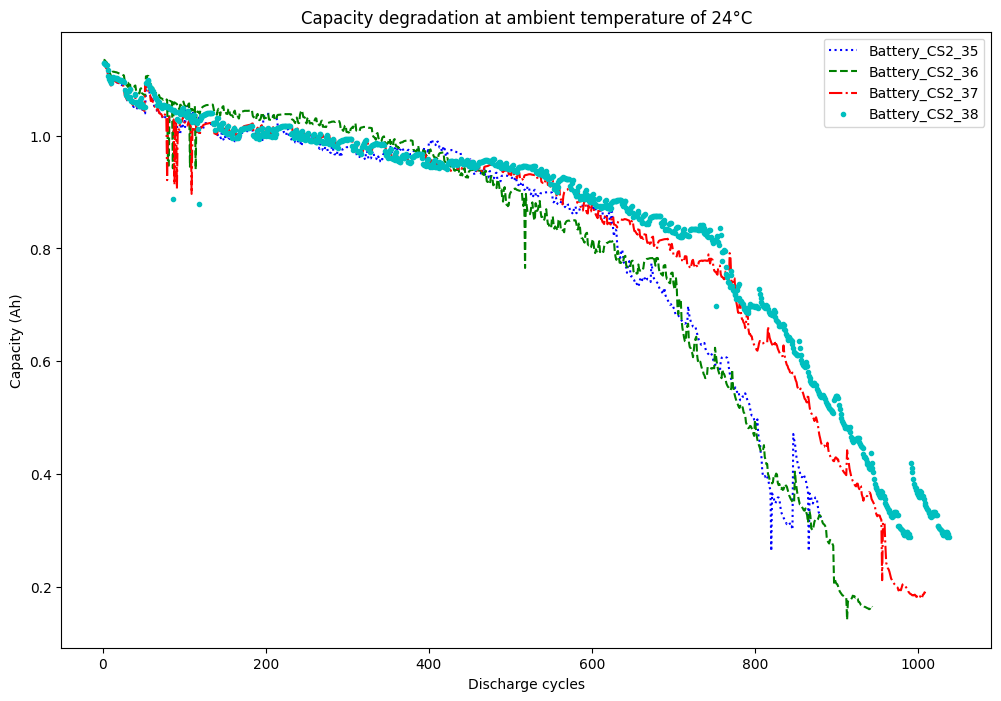

In [16]:
preprocessor.plot_capacity_degradation()